In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tableone
import warnings
import seaborn as sns

In [2]:
pd.options.display.max_columns = 200

In [3]:
data_path = pd.read_csv(
    "/Users/mxposed/Documents/data_paths/ssc.csv",
    index_col=0
).value["clinical_data"]

In [4]:
data_path = os.path.join(data_path, "processed")

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
mpl.rcParams['font.family'] = 'Arial'

# Look at disease duration

Examine disease duration and PFT function, MMF therapy and HRCT

## 1. Load all processed data

In [7]:
samples = pd.read_csv("../00all-samples.csv")

Take only our samples

In [8]:
samples = samples.loc[samples.Study.eq("this"), :].copy()

In [9]:
samples["Patient_id"] = samples.Sample

Strip `_followup` to get Redcap patient ids

In [10]:
samples.Patient_id = samples.Patient_id.str.replace("_followup$", "", regex=True)

Number of unique patients among our samples

In [11]:
samples.Patient_id.nunique()

14

In [12]:
pt_info = pd.read_csv(os.path.join(data_path, "01_pt_info.csv"), index_col=0)

In [13]:
disease_info = pd.read_csv(os.path.join(data_path, "02_disease_info.csv"), index_col=0)

In [14]:
clin_info = pd.read_csv(os.path.join(data_path, "03_clin_info.csv"), index_col=0)

In [15]:
meds_info = pd.read_csv(os.path.join(data_path, "04_meds_info.csv"), index_col=0)

In [16]:
date_info = pd.read_csv(os.path.join(data_path, "05_date_info.csv"), index_col=0)

## 2. Determine day-0 BAL per patient

In [17]:
bronchs = date_info.loc[date_info.event.eq("bronch_date")].copy()

In [18]:
bronchs["Sample"] = bronchs.study_code

In [19]:
bronchs.loc[bronchs.redcap_event_name.eq("follow_up_arm_1"), "Sample"] += "_followup"

In [20]:
bronchs = bronchs.merge(samples, on="Sample")

In [21]:
bronchs.sort_values("date", inplace=True)

In [23]:
day0_dates = bronchs.groupby("study_code").head(1)[
    ["study_code", "date"]
].set_index("study_code").date

## 3. Determine non-Raynaud symptom onset

In [24]:
non_raynaud = date_info.loc[date_info.event.eq("ssc_nonraynaud_date")].copy()

In [25]:
non_raynaud.sort_values("date", inplace=True)

In [26]:
non_raynaud_dates = non_raynaud.groupby("study_code").head(1)[
    ["study_code", "date"]
].set_index("study_code").date

In [27]:
ild_diag = date_info.loc[date_info.event.eq('ild_diag_date')].copy()

In [28]:
ild_diag.sort_values('date', inplace=True)

In [29]:
ild_diag_dates = ild_diag.set_index('study_code').date

## 4. Take Clinical values closest to BAL

This step possibly needs curation, because the closest BAL date could be miles away

In [30]:
clin_info["bal_date"] = pd.to_datetime(day0_dates[clin_info.study_code].values)

In [31]:
for col in ("crp_date", "pft_date", "monocyte_date", "tte_date", "6mwd_date"):
    clin_info[col] = pd.to_datetime(clin_info[col])
    clin_info[f"{col}_delta"] = (clin_info.bal_date - clin_info[col]).dt.days.abs()

In [32]:
idx = clin_info.dlco_ratio >= 0.85
clin_info.loc[idx, 'dlco_delta'] = (
    clin_info.bal_date[idx] - clin_info.pft_date[idx]
).dt.days.abs()
clin_info.loc[~idx, 'dlco_pred'] = np.nan

In [34]:
clin_condensed = pd.DataFrame(index=pt_info.study_code)

In [35]:
cols = {
    "crp_date": ["crp"],
    "pft_date": ["fvc_pred", "fev1_pred", "tlc_pred", "fev1_fvc", "dlco_pred"],
    "monocyte_date": ["monocyte_absolute", "monocyte_percentage"],
    "tte_date": ["echo_rvsp"],
    "6mwd_date": ["6mwd_act"]
}
for col, to_take in cols.items():
    df = clin_info.sort_values(f"{col}_delta").groupby("study_code").head(1).set_index("study_code")
    clin_condensed[to_take] = df[to_take]

In [36]:
duke_pft = pd.read_csv(os.path.join(data_path, "06_duke_pft.csv"), index_col=0).set_index('Sample')

In [38]:
for col in duke_pft.columns:
    clin_condensed.loc[duke_pft.index, col] = duke_pft[col]

Add Kazerooni scores because they are per-patient, without specific dates

In [62]:
clin_condensed_2 = clin_condensed.merge(
    clin_info[['study_code', 'k_score_ggo', 'k_score_fib']].drop_duplicates(),
    left_index=True,
    right_on='study_code',
    how='left'
)

Index was not preserved, but rows didn't change, we just copy it

In [63]:
clin_condensed_2.index = clin_condensed.index.copy()

In [64]:
clin_condensed_2.drop(columns='study_code', inplace=True)

In [ ]:
clin_condensed_2 = clin_condensed_2.reset_index().merge(
    meds_info.loc[:, ['study_code', 'cv_med_mmf_v2']],
    on='study_code',
    how='left'
).set_index('study_code').rename(columns={'cv_med_mmf_v2': 'patient_on_mmf'})

## X. Create table 1

In [66]:
data = pt_info.copy()

In [67]:
data["age_at_bal"] = pd.NaT

In [68]:
idx = data.year_of_birth.notna()
data.loc[idx, 'age_at_bal'] = (
    data.year_of_birth[idx].astype(int).astype(str) + '-01-01'
)

In [69]:
idx = data.study_code.isin(day0_dates.index)
data.loc[idx, "bal_date"] = pd.to_datetime(day0_dates[data.study_code[idx]].values)

In [70]:
data.age_at_bal = (data.bal_date - data.age_at_bal).dt.days / 365

In [71]:
idx = data.age.notna()
data.loc[idx, 'age_at_bal'] = data.age[idx]

In [72]:
idx = data.study_code.isin(non_raynaud_dates.index)
data.loc[idx, "disease_duration"] = pd.to_datetime(non_raynaud_dates[data.study_code[idx]].values)

In [73]:
data.disease_duration = (data.bal_date - data.disease_duration).dt.days / 365

In [74]:
idx = data.study_code.isin(ild_diag_dates.index)
data.loc[idx, "ild_disease_duration"] = pd.to_datetime(ild_diag_dates[data.study_code[idx]].values)

In [75]:
data.ild_disease_duration = (data.bal_date - data.ild_disease_duration).dt.days / 365

In [76]:
data.shape

(22, 14)

In [77]:
data = data.merge(disease_info, on="study_code")

In [78]:
data.smoker = data.smoker.replace({
    True: "current or former",
    False: "never"
})

In [79]:
pos = "Positive"
data["ab_any"] = (
    data.ab_scl70.eq(pos) | data.ab_aca.eq(pos) | data.ab_rnaiii.eq(pos) | data.ab_ana.eq(pos)
)
data.loc[data.disease.eq("control"), "ab_any"] = np.nan
data.ab_any = data.ab_any.replace({
    True: "positive",
    False: "negative"
})

In [80]:
for ab_col in ("ab_scl70", "ab_aca", "ab_rnaiii", "ab_ana"):
    data[ab_col] = data[ab_col].replace({"Unknown": np.nan}).str.lower()

In [81]:
data = data.merge(meds_info, on="study_code", how="left")

In [82]:
data["any_meds"] = data.cv_med_mmf_v2 | data.cv_med_pred_v2 | data.cv_med_rtx_v2

In [83]:
data.loc[data.disease.eq("control"), "any_meds"] = np.nan

In [84]:
data.any_meds = data.any_meds.replace({
    True: "taking",
    False: "not taking"
})

In [85]:
for med_col in ("cv_med_mmf_v2", "cv_med_pred_v2", "cv_med_rtx_v2"):
    data[med_col] = data[med_col].replace({
        True: "taking",
        False: "not taking"
    })

In [86]:
data = data.merge(clin_condensed_2.astype(float), on="study_code")

In [87]:
idx = data.ssc_subtype.eq('lcSSc')
data.loc[idx, 'mrss_lcssc'] = data.mrss[idx]
idx = data.ssc_subtype.eq('dcSSc')
data.loc[idx, 'mrss_dcssc'] = data.mrss[idx]

In [89]:
data['k_score_total'] = data.k_score_ggo + data.k_score_fib

In [90]:
data.cough = data.cough.replace({0: 'negative', 1: 'Cough'})

In [91]:
data.dyspnea = data.dyspnea.replace({0: 'negative', 1: 'Dyspnea'})

/Users/mxposed/Documents/Northwestern/ssc/code/clin_venv/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


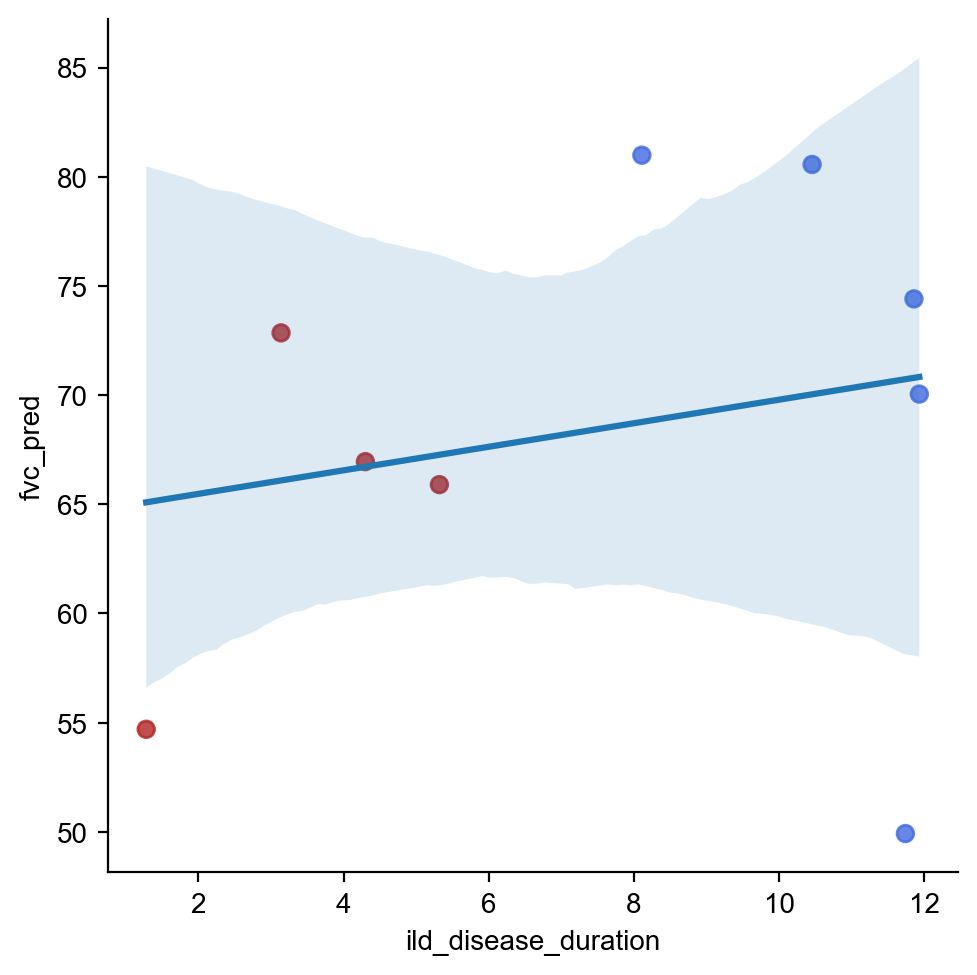

In [93]:
df = data.loc[data.disease.eq('SSc')]
sns.lmplot(
    data=df,
    x='ild_disease_duration',
    y='fvc_pred',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'royalblue', 1: 'firebrick'})
        ]
    }
)

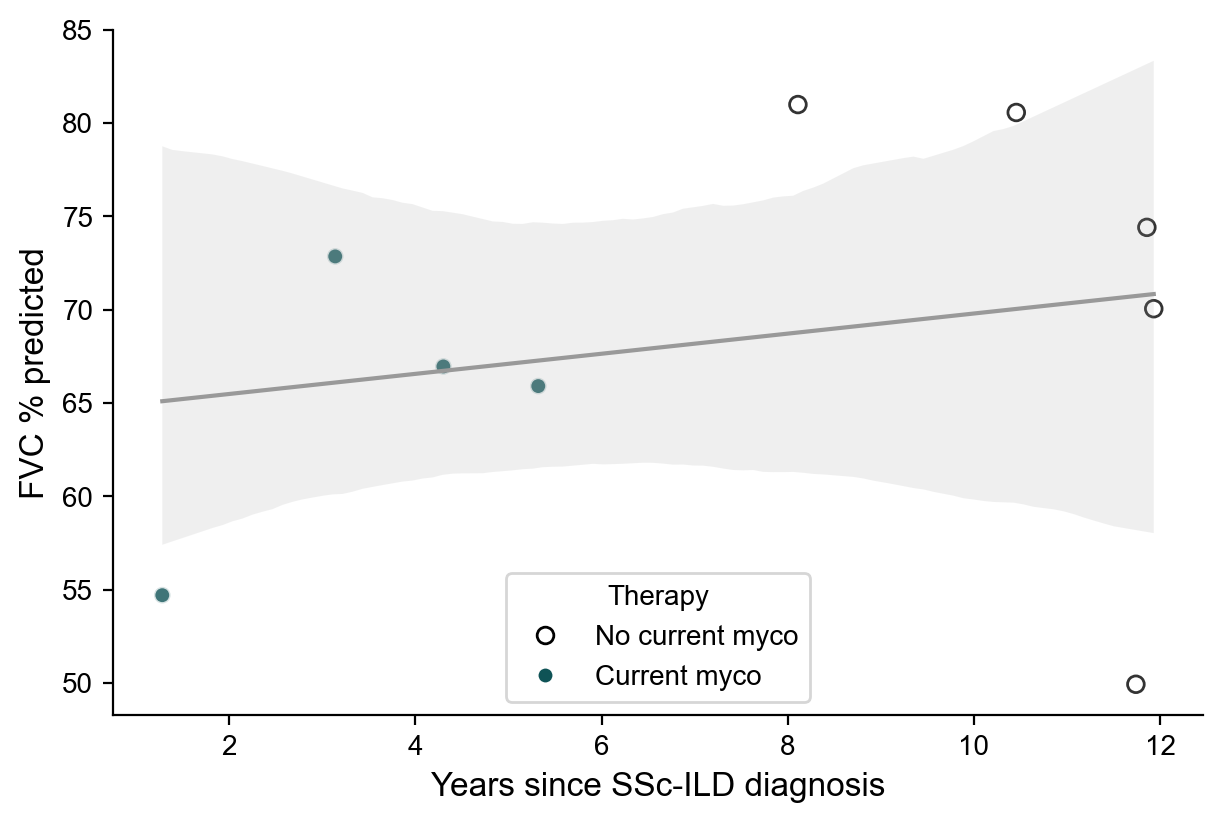

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.regplot(
    data=df,
    x='ild_disease_duration',
    y='fvc_pred',
    ax=ax,
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'white', 1: '#0f5356'})
        ],
        'ec': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'k', 1: 'w'})
        ]
    },
    line_kws={'color': '#999', 'lw': 1.5}
)
ax.set_xlabel("Years since SSc-ILD diagnosis", fontsize=12)
ax.set_ylabel("FVC % predicted", fontsize=12)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(
    handles=[
        mpl.lines.Line2D(
            [0], [0], marker='o', markerfacecolor='white',
            label='No current myco', markeredgecolor='k',
            color='#ffffffff'
        ),
        mpl.lines.Line2D(
            [0], [0], marker='o', markerfacecolor='#0f5356',
            label='Current myco',
            color='#ffffffff'
        )
    ],
    loc='lower center',
    # bbox_to_anchor=(1.05, -0.01),
    title='Therapy',
    ncol=1
)
fig.savefig('plots/Figure_S1B_fvc_vs_ild_duration.pdf')

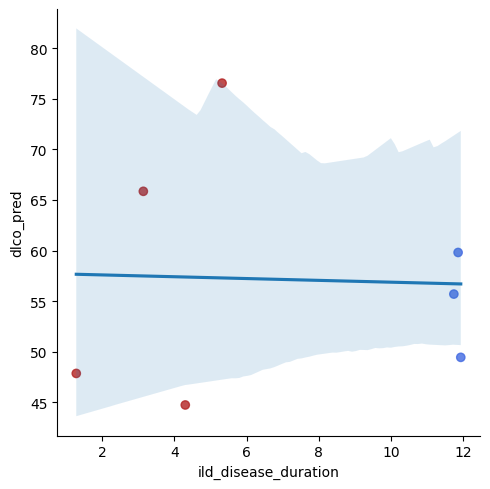

In [87]:
df = data.loc[data.disease.eq('SSc') & data.dlco_pred.notna()]
sns.lmplot(
    data=df,
    x='ild_disease_duration',
    y='dlco_pred',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'royalblue', 1: 'firebrick'})
        ]
    }
)

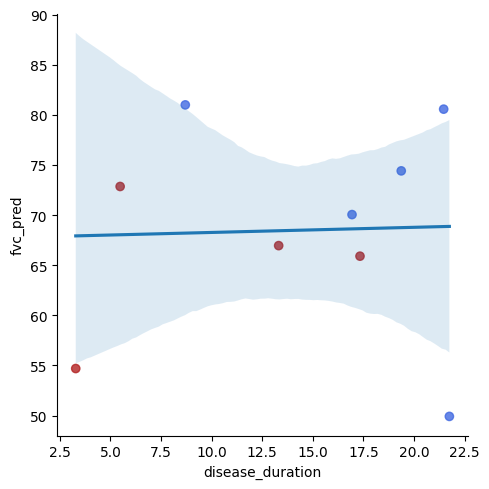

In [88]:
df = data.loc[data.disease.eq('SSc')]
sns.lmplot(
    data=df,
    x='disease_duration',
    y='fvc_pred',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'royalblue', 1: 'firebrick'})
        ]
    }
)

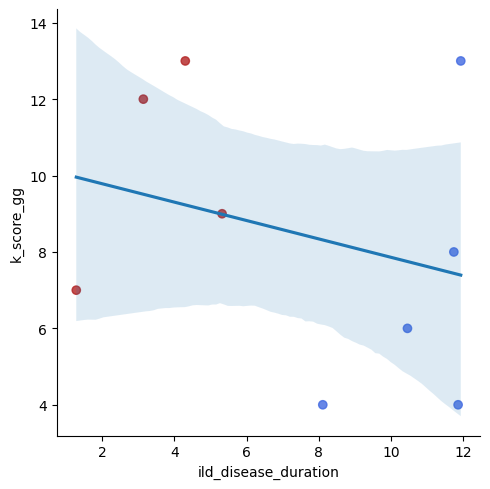

In [89]:
df = data.loc[data.disease.eq('SSc')]
sns.lmplot(
    data=df,
    x='ild_disease_duration',
    y='k_score_gg',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'royalblue', 1: 'firebrick'})
        ]
    }
)

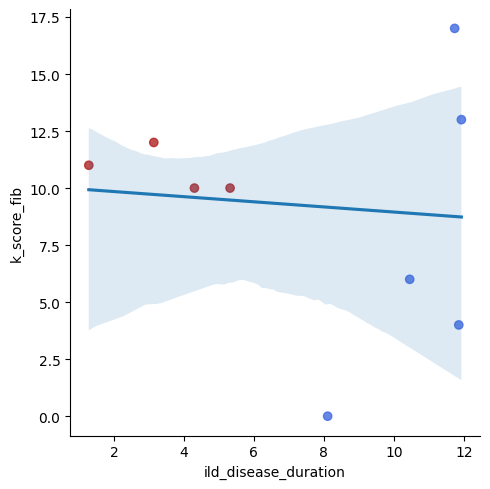

In [90]:
df = data.loc[data.disease.eq('SSc')]
sns.lmplot(
    data=df,
    x='ild_disease_duration',
    y='k_score_fib',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.patient_on_mmf.map({0: 'royalblue', 1: 'firebrick'})
        ]
    }
)